## Training

In [1]:
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
from keras.initializers import glorot_uniform

import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("models/")
sys.path.append("scripts/")

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1, 2, 3"

In [3]:
# Load the data
h5f = h5py.File('data/data_cano_distributed2.h5', 'r')
train_x, train_y = h5f['train_x'][:], h5f['train_y'][:]
valid_x, valid_y = h5f['valid_x'][:], h5f['valid_y'][:]
test_x, test_y = h5f['test_x'][:], h5f['test_y'][:]
h5f.close()

print(train_x.shape, valid_x.shape, test_x.shape)

(3011, 24, 24, 24, 16) (377, 24, 24, 24, 16) (376, 24, 24, 24, 16)


In [4]:
from models import Squeeze_model

In [5]:
# from IPython.display import SVG
# from keras.utils.vis_utils import plot_model, model_to_dot
# model_input = Input(shape=(24, 24, 24, 16))
# squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
# #plot_model(squeeze_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(squeeze_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
# # plot_model(get_model4((24, 24, 24, 16)))

In [6]:
# Training parameters
nb_gpus = 4
nb_batch = nb_gpus*3
nb_epochs =200
l_rate = 1e-5

In [7]:
# checkpoint
outputFolder = './weights'
# if not os.path.exists(outputFolder):
#     os.makedirs(outputFolder)

filepath=outputFolder+"/weights-distributed_cano_rotated_random_32.h5"

callbacks_list = [ModelCheckpoint(filepath, 
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)]

In [8]:
model_input = Input(shape=(28, 28, 28, 16))
squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
model = multi_gpu_model(squeeze_model, gpus=nb_gpus)

model.compile(optimizer=optimizers.adam(lr=l_rate),# beta_1=0.99, beta_2=0.999),
              loss='mean_absolute_error')

In [9]:
from my_classes import AugmentedDataGeneratorRandom

In [10]:
rotation_count = 32
aug_data_gen = AugmentedDataGeneratorRandom(x=train_x, y=train_y, batch_size=nb_batch, rotation_count=rotation_count)
aug_val_gen = AugmentedDataGeneratorRandom(x=valid_x, y=valid_y, batch_size=nb_batch, rotation_count=rotation_count)

In [11]:
for x, y in aug_data_gen:
    print(x.shape, y.shape)
    break

(396, 28, 28, 28, 16) (396,)


In [12]:
history = model.fit_generator(generator=aug_data_gen, validation_data=aug_val_gen,
                              use_multiprocessing=False, 
                              epochs=nb_epochs, 
                              max_queue_size=6, 
                              workers=56, 
                              verbose=1, callbacks=callbacks_list)

Epoch 1/200
250/250 [==============================] - 290s 1s/step - loss: 2.6821 - val_loss: 1.5166

Epoch 00001: val_loss improved from inf to 1.51661, saving model to ./weights/weights-distributed_cano_rotated_random_32.h5
Epoch 2/200
250/250 [==============================] - 309s 1s/step - loss: 1.6603 - val_loss: 1.4712

Epoch 00002: val_loss improved from 1.51661 to 1.47115, saving model to ./weights/weights-distributed_cano_rotated_random_32.h5
Epoch 3/200
250/250 [==============================] - 332s 1s/step - loss: 1.5716 - val_loss: 1.4100

Epoch 00003: val_loss improved from 1.47115 to 1.41000, saving model to ./weights/weights-distributed_cano_rotated_random_32.h5
Epoch 4/200
250/250 [==============================] - 328s 1s/step - loss: 1.6014 - val_loss: 1.5156

Epoch 00004: val_loss did not improve from 1.41000
Epoch 5/200
250/250 [==============================] - 327s 1s/step - loss: 1.5494 - val_loss: 1.5977

Epoch 00005: val_loss did not improve from 1.41000
Epo

250/250 [==============================] - 319s 1s/step - loss: 1.4988 - val_loss: 1.3298

Epoch 00051: val_loss did not improve from 1.32058
Epoch 52/200
250/250 [==============================] - 324s 1s/step - loss: 1.4906 - val_loss: 1.4178

Epoch 00052: val_loss did not improve from 1.32058
Epoch 53/200
250/250 [==============================] - 327s 1s/step - loss: 1.4611 - val_loss: 1.4206

Epoch 00053: val_loss did not improve from 1.32058
Epoch 54/200
250/250 [==============================] - 324s 1s/step - loss: 1.4363 - val_loss: 1.3417

Epoch 00054: val_loss did not improve from 1.32058
Epoch 55/200
250/250 [==============================] - 323s 1s/step - loss: 1.4689 - val_loss: 1.4931

Epoch 00055: val_loss did not improve from 1.32058
Epoch 56/200
250/250 [==============================] - 327s 1s/step - loss: 1.3972 - val_loss: 1.4179

Epoch 00056: val_loss did not improve from 1.32058
Epoch 57/200
250/250 [==============================] - 327s 1s/step - loss: 1.4323

250/250 [==============================] - 327s 1s/step - loss: 1.3708 - val_loss: 1.4923

Epoch 00103: val_loss did not improve from 1.23961
Epoch 104/200
250/250 [==============================] - 329s 1s/step - loss: 1.4495 - val_loss: 1.3754

Epoch 00104: val_loss did not improve from 1.23961
Epoch 105/200
250/250 [==============================] - 330s 1s/step - loss: 1.4294 - val_loss: 1.3145

Epoch 00105: val_loss did not improve from 1.23961
Epoch 106/200
250/250 [==============================] - 324s 1s/step - loss: 1.4117 - val_loss: 1.4546

Epoch 00106: val_loss did not improve from 1.23961
Epoch 107/200
250/250 [==============================] - 330s 1s/step - loss: 1.3758 - val_loss: 1.3075

Epoch 00107: val_loss did not improve from 1.23961
Epoch 108/200
250/250 [==============================] - 329s 1s/step - loss: 1.4098 - val_loss: 1.3045

Epoch 00108: val_loss did not improve from 1.23961
Epoch 109/200
250/250 [==============================] - 327s 1s/step - loss: 

250/250 [==============================] - 323s 1s/step - loss: 1.3837 - val_loss: 1.2487

Epoch 00155: val_loss did not improve from 1.21397
Epoch 156/200
250/250 [==============================] - 327s 1s/step - loss: 1.3807 - val_loss: 1.3165

Epoch 00156: val_loss did not improve from 1.21397
Epoch 157/200
250/250 [==============================] - 322s 1s/step - loss: 1.3808 - val_loss: 1.2869

Epoch 00157: val_loss did not improve from 1.21397
Epoch 158/200
250/250 [==============================] - 328s 1s/step - loss: 1.3686 - val_loss: 1.3300

Epoch 00158: val_loss did not improve from 1.21397
Epoch 159/200
250/250 [==============================] - 324s 1s/step - loss: 1.3482 - val_loss: 1.2541

Epoch 00159: val_loss did not improve from 1.21397
Epoch 160/200
250/250 [==============================] - 325s 1s/step - loss: 1.3835 - val_loss: 1.4648

Epoch 00160: val_loss did not improve from 1.21397
Epoch 161/200
250/250 [==============================] - 328s 1s/step - loss: 

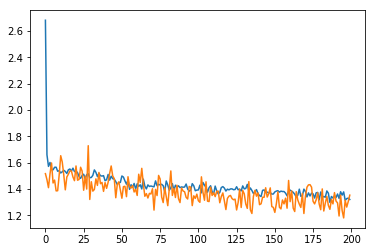

In [13]:
# First 100 epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [14]:
# Save the history
import pickle

with open(os.path.join(outputFolder, "history_distributed_cano_rotated_random_32.pickle"), 'wb') as f:
    pickle.dump(history.history, f)

In [15]:
# Save the weights
# model.save_weights('weights/weights_distributed_cano_rotated_random_32.h5')
model.load_weights(filepath)

In [16]:
from sklearn.metrics import r2_score

In [17]:
rotation_count = 32
sample_size = 200

In [18]:
train_aug_data_gen = AugmentedDataGeneratorRandom(x=train_x[:sample_size],
                                            y=train_y[:sample_size],
                                            batch_size=sample_size,
                                            rotation_count=rotation_count)

test_aug_data_gen = AugmentedDataGeneratorRandom(x=test_x[:sample_size],
                                            y=test_y[:sample_size],
                                            batch_size=sample_size,
                                            rotation_count=rotation_count)

In [19]:
# Train r2

for x, y in train_aug_data_gen:
    # Without average
    train_r2 = r2_score(y_true=y, y_pred=model.predict(x))
    print("Train r2 (without average): ", train_r2)
    
    # With average
    y_pred = model.predict(x)[:, 0]
    
    sample_y = np.zeros(sample_size)
    sample_ypred = np.zeros(sample_size)
    for i in range(sample_size):
        start = i*(rotation_count+1)
        end = i*(rotation_count+1) + (rotation_count+1)
        mean_ypred = np.mean(y_pred[start:end])
        mean_y = np.mean(y[start:end])
        sample_ypred[i] = mean_ypred
        sample_y[i] = mean_y
    
    train_r2 = r2_score(y_true=sample_y, y_pred=sample_ypred)
    print("Train r2 (with average): ", train_r2)
    break

Train r2 (without average):  0.331565234772
Train r2 (with average):  0.349897293715


In [23]:
# Test r2

for x, y in test_aug_data_gen:
    # Without average
    test_r2 = r2_score(y_true=y, y_pred=model.predict(x))
    print("Test r2 (without average): ", test_r2)
    
    # With average
    y_pred = model.predict(x)[:, 0]
    
    sample_y = np.zeros(sample_size)
    sample_ypred = np.zeros(sample_size)
    for i in range(sample_size):
        start = i*(rotation_count+1)
        end = i*(rotation_count+1) + (rotation_count+1)
        mean_ypred = np.mean(y_pred[start:end])
        mean_y = np.mean(y[start:end])
        sample_ypred[i] = mean_ypred
        sample_y[i] = mean_y
    
    test_r2 = r2_score(y_true=sample_y, y_pred=sample_ypred)
    print("Test r2 (with average): ", test_r2)
    break

Test r2 (without average):  0.285065648409
Test r2 (with average):  0.306119653811


In [24]:
myvar = 0.0

def f1():
    print(myvar)
    myvar = 5
    print(myvar)
def f2():
    global myvar
    print(myvar)
    myvar = 10
    print(myvar)
    

In [26]:
f2()

0.0
10


In [27]:
myvar

10